#  Framework: Current Status and Recent Updates

### Warning: This tutorial assumes some familiarity with columnar analysis and the uproot+awkward way of dealing with HEP data

## Scope of this tutorial
This tutorial is meant to present the current status of the `coffea` framework and the recent updates we had this past year.

## Columnar analysis and coffea
What is `coffea`? Coffea (Columnar Object Framework For Effective Analysis) is a set of basic tools and wrappers for enabling not-too-alien syntax when running columnar Collider HEP analysis.

What is columnar analysis:

* Event loop analysis:
    - Load relevant values for a specific event into local variables
    - Evaluate several expressions
    - Store derived values
    - Repeat (explicit outer loop)
* Columnar analysis:
    - Load relevant values for many events into contiguous arrays
    - Evaluate several array programming expressions
        - Implicit inner loops
        - Plan analysis by composing data manipulations
    - Store derived values

In physics we're dealing with [jagged or ragged arrays](https://en.wikipedia.org/wiki/Jagged_array). A ragged array is something like this:

```
[[1, 2, 3],
 [4],
 [],
 [5, 6]]
---------------------
type: 4 * var * int64
```

In the pythonic HEP ecosystem, we deal with those kinds of arrays using [awkward](https://github.com/scikit-hep/awkward). Awkward Arrays are general tree-like data structures, like JSON, but contiguous in memory and operated upon with compiled, vectorized code like NumPy. For more information, please visit the [awkward array docs](https://awkward-array.org/doc/main/index.html) and/or see [previous talks from Jim Pivarski](https://github.com/jpivarski-talks/).

## NanoEvents

NanoEvents is a Coffea utility to wrap flat nTuple structures (such as the CMS [NanoAOD](https://www.epj-conferences.org/articles/epjconf/pdf/2019/19/epjconf_chep2018_06021.pdf) format) into a single awkward array with appropriate object methods (such as Lorentz vector methods$^*$), cross references, and nested objects, all accessed from the source ROOT TTree via uproot. The interpretation of the TTree data is configurable via [schema objects](https://coffea-hep.readthedocs.io/en/latest/modules/coffea.nanoevents.html#classes), which are community-supplied  for various source file types. These schema objects allow a richer interpretation of the file contents than the `uproot` methods. Currently available schemas include:

   - `BaseSchema`, which provides a simple representation of the input TTree, where each branch is available verbatim as `events.branch_name`.  Any branches that uproot supports at "full speed" (i.e. that are fully split and either flat or single-jagged) can be read by this schema;
   - `NanoAODSchema`, which is optimized to provide all methods and cross-references in CMS NanoAOD format;
   - `PFNanoAODSchema`, which builds a double-jagged particle flow candidate colllection `events.jet.constituents` from compatible PFNanoAOD input files;
   - `TreeMakerSchema` which is designed to read TTrees made by [TreeMaker](https://github.com/TreeMaker/TreeMaker), an alternative CMS nTuplization format;
   - `PHYSLITESchema`, for the ATLAS DAOD_PHYSLITE derivation, a compact centrally-produced data format similar to CMS NanoAOD; and
   - `DelphesSchema`, for reading Delphes fast simulation [nTuples](https://cp3.irmp.ucl.ac.be/projects/delphes/wiki/WorkBook/RootTreeDescription).

We welcome contributions for new schemas, and can assist with the design of them.

$^*$ Vector methods are currently made possible via the [coffea vector](https://coffea-hep.readthedocs.io/en/latest/modules/coffea.nanoevents.methods.vector.html) methods mixin class structure. In a future version of coffea, they will instead be provided by the dedicated scikit-hep [vector](https://vector.readthedocs.io/en/latest/) library, which provides a more rich feature set. The coffea vector methods predate the release of the vector library.

In this demo, we will use NanoEvents to read a small CMS NanoAOD sample. The events object can be instantiated as follows:

In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

NanoAODSchema.warn_missing_crossrefs = False

In the factory constructor, we also pass the desired schema version for this file and some extra metadata that we can later access with `events.metadata`. In a later example, we will show how to set up this metadata in coffea processors where the `events` object is pre-created for you. Consider looking at the [from_root](https://coffea-hep.readthedocs.io/en/latest/api/coffea.nanoevents.NanoEventsFactory.html#coffea.nanoevents.NanoEventsFactory.from_root) class method to see all optional arguments.

In [2]:
fname = "data/nano_dy.root"
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=BaseSchema,
    mode="eager",
    metadata={"dataset": "DYJets"},
).events()

In [3]:
events.Electron_pt

<Array [[], [29.6], [60.1, ...], ..., [], []] type='40 * var * float32[para...'>

But with `BaseSchema`, we are not getting anything more than a plain `uproot.open(...).arrays()` gets us. Since this is a `NanoAOD` file, let's use `NanoAODSchema`. This allows us to structure our array in a way that is very meaningful to do physics with.

In [4]:
fname = "data/nano_dy.root"
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    mode="eager",
    metadata={"dataset": "DYJets"},
).events()

The `events` object is an awkward array, which at its top level is a record array with one record for each "collection", where a collection is a grouping of fields (TBranches) based on the naming conventions of [NanoAODSchema](https://coffea-hep.readthedocs.io/en/latest/api/coffea.nanoevents.NanoAODSchema.html). For example, in the file we opened, the branches:
```
Generator_binvar
Generator_scalePDF
Generator_weight
Generator_x1
Generator_x2
Generator_xpdf1
Generator_xpdf2
Generator_id1
Generator_id2
```
are grouped into one sub-record named `Generator` which can be accessed using either getitem or getattr syntax, i.e. `events["Generator"]` or `events.Generator`. e.g.

In [5]:
events.Generator.id1

<Array [1, -1, -1, 21, 21, ..., -2, -1, 2, 1] type='40 * int32[parameters={...'>

In [6]:
# all names can be listed with:
events.Generator.fields

['binvar', 'scalePDF', 'weight', 'x1', 'x2', 'xpdf1', 'xpdf2', 'id1', 'id2']

Based on a collection's name or contents, some collections acquire additional _methods_, which are extra features exposed by the code in the mixin classes of the `coffea.nanoevents.methods` modules. For example, although `events.GenJet` has the fields:

In [7]:
events.GenJet.fields

['eta', 'mass', 'phi', 'pt', 'partonFlavour', 'hadronFlavour']

we can access additional attributes associated to each generated jet by virtue of the fact that they can be interpreted as [Lorentz vectors](https://coffea-hep.readthedocs.io/en/latest/api/coffea.nanoevents.methods.vector.LorentzVector.html#coffea.nanoevents.methods.vector.LorentzVector):

In [8]:
events.GenJet.energy

<Array [[217, 670, 258], [...], ..., [76.9]] type='40 * var * float32[param...'>

We can call more complex methods, like computing the distance $\Delta R = \sqrt{\Delta \eta^2 + \Delta \phi ^2}$ between two LorentzVector objects:

In [9]:
# find distance between leading jet and all electrons in each event
dr = events.Jet[:, 0].delta_r(events.Electron)
dr

<Array [[], [3.13], [3.45, ...], ..., [], []] type='40 * var * float32[para...'>

In [10]:
# find minimum distance
drmin = ak.min(dr, axis=1)
drmin

<Array [None, 3.13, 2.18, 1.58, ..., 0.0858, None, None] type='40 * ?float32'>

In [11]:
# a convenience method for this operation on all jets is available
events.Jet.nearest(events.Electron)

<ElectronArray [[None, None, ..., None, None], ...] type='40 * var * ?Elect...'>

The assignment of methods classes to collections is done inside the schema object during the initial creation of the array, governed by the awkward array's `__record__` parameter and the associated behavior. See [ak.behavior](https://awkward-array.readthedocs.io/en/latest/ak.behavior.html) for a more detailed explanation of array behaviors.

Additional methods provide convenience functions for interpreting some branches, e.g. CMS NanoAOD packs several jet identification flag bits into a single integer, `jetId`. By implementing the bit-twiddling in the [Jet mixin](https://github.com/CoffeaTeam/coffea/blob/7045c06b9448d2be4315e65d432e6d8bd117d6d7/coffea/nanoevents/methods/nanoaod.py#L279-L282), the analsyis code becomes more clear:

In [12]:
print(events.Jet.jetId)
print(events.Jet.isTight)

[[6, 6, 6, 6, 6], [6, 2, 6, 6, 6, 6, 6, 0], ..., [6, 6, 0, ..., 6, 6], [6, 6]]
[[True, True, True, True, True], [True, True, ..., False], ..., [True, True]]


We can also define convenience functions to unpack and apply some mask to a set of flags, e.g. for generated particles:

In [13]:
print(f"Raw status flags: {events.GenPart.statusFlags}")
events.GenPart.hasFlags(["isPrompt", "isLastCopy"])

Raw status flags: [[10625, 27009, 4481, 22913, 257, ..., 13884, 13884, 13884, 12876, 12876], ...]


<Array [[True, True, ..., False, False], ...] type='40 * var * bool[paramet...'>

CMS NanoAOD also contains pre-computed cross-references for some types of collections. For example, there is a TBranch `Electron_genPartIdx` which indexes the `GenPart` collection per event to give the matched generated particle, and `-1` if no match is found. NanoEvents transforms these indices into an awkward _indexed array_ pointing to the collection, so that one can directly access the matched particle using getattr syntax:

In [14]:
events.Electron.matched_gen.pdgId

<Array [[], [-11], [-11, 11], ..., [], []] type='40 * var * ?int32[paramete...'>

In [15]:
events.Muon[ak.num(events.Muon) > 0].matched_jet.pt

<Array [[84.4, 29.4], [31.1], ..., [25.8]] type='12 * var * ?float32[parame...'>

For generated particles, the parent index is similarly mapped:

In [16]:
events.GenPart.parent.pdgId

<Array [[None, None, 1, ..., 111, 111], ...] type='40 * var * ?int32[parame...'>

In addition, using the parent index, a helper method computes the inverse mapping, namely, `children`. As such, one can find particle siblings with:

In [17]:
events.GenPart.parent.children.pdgId
# notice this is a doubly-jagged array

<Array [[None, None, ..., [22, 22]], ...] type='40 * var * option[var * ?in...'>

Since often one wants to shortcut repeated particles in a decay sequence, a helper method `distinctParent` is also available. Here we use it to find the parent particle ID for all prompt electrons:

In [18]:
events.GenPart[
    (abs(events.GenPart.pdgId) == 11)
    & events.GenPart.hasFlags(["isPrompt", "isLastCopy"])
].distinctParent.pdgId

<Array [[], [23, 23], [...], ..., [23, 23], []] type='40 * var * ?int32[par...'>

Events can be filtered like any other awkward array using boolean fancy-indexing

In [19]:
mmevents = events[ak.num(events.Muon) == 2]
zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
zmm.mass

<Array [94.6, 87.6, 88, 90.4, 89.1, 31.6] type='6 * float32[parameters={"ty...'>

In [20]:
# a convenience method is available to sum vectors along an axis:
mmevents.Muon.sum(axis=1).mass

<Array [94.6, 87.6, 88, 90.4, 89.1, 31.6] type='6 * float32'>

As expected for this sample, most of the dimuon events have a pair invariant mass close to that of a Z boson. But what about the last event? Let's take a look at the generator information:

In [21]:
print(mmevents[-1].Muon.matched_gen.pdgId)
print(mmevents[-1].Muon.matched_gen.hasFlags(["isPrompt"]))

[-13, 13]
[False, False]


So they are real generated muons, but they are not prompt (i.e. from the initial decay of a heavy resonance)

Let's look at their parent particles:

In [22]:
mmevents[-1].Muon.matched_gen.parent.pdgId

<Array [-15, 15] type='2 * ?int32[parameters={"__doc__": "PDG id", "typenam...'>

aha! They are muons coming from tau lepton decays, and hence a fair amount of the Z mass is carried away by the neutrinos:

In [23]:
print(mmevents.Muon.matched_gen.sum().mass[-1])
print(mmevents.Muon.matched_gen.parent.sum().mass[-1])

31.265434
91.683304


One can assign new variables to the arrays, with some caveats:

 * Assignment must use setitem (`events["path", "to", "name"] = value`)
 * Assignment to a sliced `events` won't be accessible from the original variable
 * New variables are not visible from cross-references

In [24]:
mmevents["Electron", "myvariable"] = mmevents.Electron.pt + zmm.mass
mmevents.Electron.myvariable

<Array [[], [121], [], [], [], []] type='6 * var * float32[parameters={"typ...'>

### NanoEvents virtual mode

In [25]:
fname = "data/nano_dy.root"
access_log = []
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    mode="virtual",  # is the default
    metadata={"dataset": "DYJets"},
    access_log=access_log,
).events()
print(access_log)

[]


In [26]:
print(events.Electron.pt)

[??, ??, ??, ??, ??, ??, ??, ??, ??, ..., ??, ??, ??, ??, ??, ??, ??, ??, ??]


Everything is lazy until required by an operation. For example, multiplying an array by 1 will load it and the loaded array gets cached onto the itself.

In [27]:
print(events.Electron.pt * 1)
print(access_log)

[[], [29.6], [60.1, 51.7], [10.7, 8.6], [], ..., [15.6], [], [7.68], [], []]
['nElectron', 'Electron_pt']


In [28]:
print(events.Electron.pt)

[[], [29.6], [60.1, 51.7], [10.7, 8.6], [], ..., [15.6], [], [7.68], [], []]


Things that only need the shape will load only that.

In [29]:
print(ak.zeros_like(events.Muon.pt))
print(access_log)

[[], [], [], [], [0, 0], [0], [0, 0], [], ..., [], [], [0], [], [], [], [], []]
['nElectron', 'Electron_pt', 'nMuon']


There is also a high-level `ak.materialize` function that traverses the input array and materializes any virtual buffers (and returns a new array).

In [30]:
print(ak.materialize(events.Muon.eta))
print(access_log)

[[], [], [], [], [0.714, 2.36], [-0.621], ..., [-0.496], [], [], [], [], []]
['nElectron', 'Electron_pt', 'nMuon', 'Muon_eta']


In [31]:
print(ak.materialize(events.GenJet))
print(access_log)

[[{eta: 1.55, mass: 12.4, phi: -0.922, pt: 87.5, ...}, {...}, {...}], ...]
['nElectron', 'Electron_pt', 'nMuon', 'Muon_eta', 'nGenJet', 'GenJet_eta', 'GenJet_mass', 'GenJet_phi', 'GenJet_pt', 'GenJet_partonFlavour', 'GenJet_hadronFlavour']


You don't need to think about virtual arrays more than what we just mentioned. Lazy loading comes for free without mental overhead to the physicist.

In [32]:
print(events.Jet[:, 0].delta_r(events.Electron))
print(access_log)

[[], [3.13], [3.45, 2.18], [1.58, 3.76], [], ..., [], [0.0858], [], []]
['nElectron', 'Electron_pt', 'nMuon', 'Muon_eta', 'nGenJet', 'GenJet_eta', 'GenJet_mass', 'GenJet_phi', 'GenJet_pt', 'GenJet_partonFlavour', 'GenJet_hadronFlavour', 'nJet', 'Jet_pt', 'Jet_phi', 'Jet_eta', 'Electron_phi', 'Electron_eta']


In [33]:
print(events.Jet.jetId)

[??, ??, ??, ??, ??, ??, ??, ??, ??, ..., ??, ??, ??, ??, ??, ??, ??, ??, ??]


In [34]:
print(events.Jet.isTight)
print(access_log)

[[True, True, True, True, True], [True, True, ..., False], ..., [True, True]]
['nElectron', 'Electron_pt', 'nMuon', 'Muon_eta', 'nGenJet', 'GenJet_eta', 'GenJet_mass', 'GenJet_phi', 'GenJet_pt', 'GenJet_partonFlavour', 'GenJet_hadronFlavour', 'nJet', 'Jet_pt', 'Jet_phi', 'Jet_eta', 'Electron_phi', 'Electron_eta', 'Jet_jetId']


In [35]:
print(events.Jet.jetId)

[[6, 6, 6, 6, 6], [6, 2, 6, 6, 6, 6, 6, 0], ..., [6, 6, 0, ..., 6, 6], [6, 6]]


In [36]:
mmevents = events[ak.num(events.Muon) == 2]
zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
print(zmm.mass)
print(access_log)

[94.6, 87.6, 88, 90.4, 89.1, 31.6]
['nElectron', 'Electron_pt', 'nMuon', 'Muon_eta', 'nGenJet', 'GenJet_eta', 'GenJet_mass', 'GenJet_phi', 'GenJet_pt', 'GenJet_partonFlavour', 'GenJet_hadronFlavour', 'nJet', 'Jet_pt', 'Jet_phi', 'Jet_eta', 'Electron_phi', 'Electron_eta', 'Jet_jetId', 'Muon_pt', 'Muon_phi', 'Muon_mass', 'Muon_charge']


## Analysis tools

In [37]:
fname = "data/nano_dy.root"
access_log = []
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    mode="virtual",
    access_log=access_log,
).events()

### Weights

This is a container for event weights and associated systematic shifts, which helps track the product of the weights (i.e. the total event weight to be used for filling histograms) as well as systematic variations to that product. Here we demo its use by constructing an event weight consisting of the generator weight, the $\alpha_s$ uncertainty variation, and the electron ID scale factor with its associated systematic.

In [38]:
from coffea.analysis_tools import Weights

weights = Weights(len(events))

weights.add("genWeight", events.genWeight)

weights.add(
    "alphaS",
    # in NanoAOD, the generator weights are already stored with respect to nominal
    weight=ak.ones_like(events.run, dtype=float),
    # 31 => alphas(MZ)=0.1165 central value; 32 => alphas(MZ)=0.1195
    # per https://lhapdfsets.web.cern.ch/current/PDF4LHC15_nnlo_30_pdfas/PDF4LHC15_nnlo_30_pdfas.info
    # which was found by looking up the LHA ID in events.LHEPdfWeight.__doc__
    weightUp=events.LHEPdfWeight[:, 32],
    weightDown=events.LHEPdfWeight[:, 31],
)

A [WeightStatistics](https://coffea-hep.readthedocs.io/en/latest/api/coffea.analysis_tools.WeightStatistics.html) object tracks the smallest and largest weights seen per type, as well as some other summary statistics. It is kept internally and can be accessed via `weights.weightStatistics`. This object is addable, so it can be used in an accumulator.

In [39]:
weights.weightStatistics

{'genWeight': WeightStatistics(sumw=578762.4375, sumw2=27678371840.0, minw=-26331.201171875, maxw=26331.201171875, n=40),
 'alphaS': WeightStatistics(sumw=40.0, sumw2=40.0, minw=1.0, maxw=1.0, n=40)}

Then the total event weight is available via

In [40]:
weights.weight()

array([ 26331.20117188,  26331.20117188,  26331.20117188,  25807.2109375 ,
        26331.20117188,  26331.20117188, -26331.20117188,  26067.890625  ,
        26331.20117188,  26331.20117188,  26331.20117188,  26331.20117188,
        26331.20117188, -26331.20117188,  26331.20117188,  26331.20117188,
       -26067.890625  ,  26331.20117188, -26331.20117188,  26331.20117188,
        26331.20117188, -26331.20117188,  26331.20117188,  26331.20117188,
        26331.20117188,  26331.20117188,  26331.20117188,  26331.20117188,
        26331.20117188,  26331.20117188,  26331.20117188,  26331.20117188,
        26331.20117188, -26331.20117188,  26331.20117188, -26331.20117188,
        26331.20117188, -26331.20117188,  26331.20117188, -26331.20117188])

And the total event weight with a given variation is available via

In [41]:
weights.weight("alphaSUp")

array([ 25842.63396263,  24895.23143023,  25890.04426748,  25103.12016058,
        24973.17718565,  28240.47039747, -28253.32742929,  24091.79686546,
        26303.87997925,  26445.3073293 ,  26115.04232436,  26320.75483352,
        25440.85171819, -25649.7784853 ,  27149.22982156,  26511.19961739,
       -24195.21562099,  26866.37512147, -25583.08263272,  27676.36812627,
        26130.31004965, -27480.29839098,  26782.80441463,  26292.63007641,
        24529.60958779,  26143.97064596,  26094.14964765,  27076.90901756,
        25505.1368773 ,  26458.16436112,  26596.37745321,  25305.04931957,
        27268.15736592, -27816.18834734,  24942.64173508, -26042.72152036,
        26496.73545659, -25627.27867961,  26901.73195899, -25277.72812694])

all variations tracked by the `weights` object are available via

In [42]:
weights.variations

{'alphaSDown', 'alphaSUp'}

### PackedSelection

This class can store several boolean arrays in a memory-efficient mannner and evaluate arbitrary combinations of boolean requirements in an CPU-efficient way. Supported inputs include 1D numpy or awkward arrays. This makes it a good tool to form analysis signal and control regions, and to implement cutflow or "N-1" plots.

Below we create a packed selection with some typical selections for a Z+jets study, to be used later to form same-sign and opposite-sign $ee$ and $\mu\mu$ event categories/regions.

In [43]:
from coffea.analysis_tools import PackedSelection

selection = PackedSelection()

selection.add("twoElectron", ak.num(events.Electron, axis=1) == 2)
selection.add("eleOppSign", ak.sum(events.Electron.charge, axis=1) == 0)
selection.add("noElectron", ak.num(events.Electron, axis=1) == 0)

selection.add("twoMuon", ak.num(events.Muon, axis=1) == 2)
selection.add("muOppSign", ak.sum(events.Muon.charge, axis=1) == 0)
selection.add("noMuon", ak.num(events.Muon, axis=1) == 0)


selection.add(
    "leadPt20",
    # assuming one of `twoElectron` or `twoMuon` is imposed, this implies at least one is above threshold
    ak.any(events.Electron.pt >= 20.0, axis=1) | ak.any(events.Muon.pt >= 20.0, axis=1),
)

print(selection.names)

['twoElectron', 'eleOppSign', 'noElectron', 'twoMuon', 'muOppSign', 'noMuon', 'leadPt20']


To evaluate a boolean mask (e.g. to filter events) we can use the `selection.all(*names)` function, which will compute the AND of all listed boolean selections

In [44]:
selection.all("twoElectron", "noMuon", "leadPt20")

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

We can also be more specific and require that a specific set of selections have a given value (with the unspecified ones allowed to be either true or false) using `selection.require`

In [45]:
selection.require(twoElectron=True, noMuon=True, eleOppSign=False)

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

Using the python syntax for passing an arguments variable, we can easily implement a "N-1" style selection

In [46]:
allCuts = ["twoElectron", "noMuon", "leadPt20"]
results = {}
for cut in allCuts:
    nev = ak.sum(selection.all(*(set(allCuts) - {cut})), axis=0)
    results[cut] = nev

results["None"] = ak.sum(selection.all(*allCuts), axis=0)

for cut, nev in results.items():
    print(f"Events passing all cuts, ignoring {cut}: {nev}")

Events passing all cuts, ignoring twoElectron: 10
Events passing all cuts, ignoring noMuon: 3
Events passing all cuts, ignoring leadPt20: 5
Events passing all cuts, ignoring None: 3


Luckily coffea implements a helper for that and also for a "Cutflow" selection (with `.cutflow`)

In [47]:
nminusone = selection.nminusone("twoElectron", "noMuon", "leadPt20")
nminusone

NminusOne(selections=('twoElectron', 'noMuon', 'leadPt20'), commonmasked=False, weighted=False, weightsmodifier=None)

In [48]:
nminusone.print()

N-1 selection stats:

Ignoring twoElectron         pass = 10                  all = 40                  -- eff = 25.0 %

Ignoring noMuon              pass = 3                   all = 40                  -- eff = 7.5 %

Ignoring leadPt20            pass = 5                   all = 40                  -- eff = 12.5 %

All cuts                     pass = 3                   all = 40                  -- eff = 7.5 %

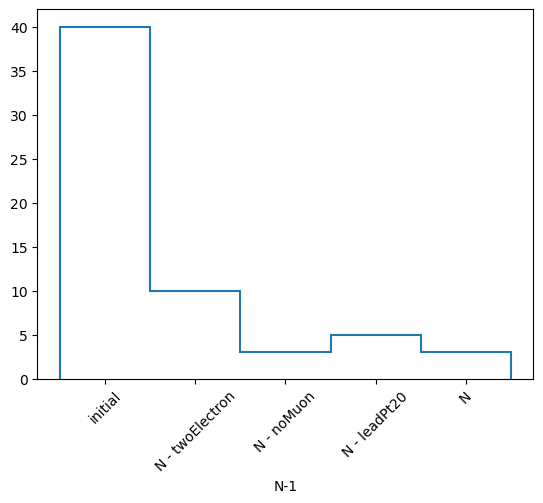

In [49]:
from matplotlib import pyplot as plt

h, labels = nminusone.yieldhist()
h.plot()
plt.xticks(plt.gca().get_xticks(), labels, rotation=45)
plt.show()

## Coffea Processors
Coffea relies mainly on [uproot](https://github.com/scikit-hep/uproot) to provide access to ROOT files for analysis.
As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done to build a parallelized framework to process the data in a reasonable amount of time. 

Since the beginning a `coffea.processor` module was provided to encapsulate the core functionality of the analysis, which could be run locally or distributed via a number of Executors. This allowed users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together).

Let's start by writing a simple processor class that reads some CMS open data and plots a dimuon mass spectrum.
We'll start by copying the [ProcessorABC](https://coffea-hep.readthedocs.io/en/latest/api/coffea.processor.ProcessorABC.html#coffea.processor.ProcessorABC) skeleton and filling in some details:

 * Remove `flag`, as we won't use it
 * Adding a new histogram for $m_{\mu \mu}$
 * Building a [Candidate](https://coffea-hep.readthedocs.io/en/latest/api/coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate.html#coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate) record for muons, since we will read it with `BaseSchema` interpretation (the files used here could be read with `NanoAODSchema` but we want to show how to build vector objects from other TTree formats) 
 * Calculating the dimuon invariant mass

In [50]:
import awkward as ak
from hist import Hist
from matplotlib import pyplot as plt

from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema


class MyProcessor(processor.ProcessorABC):
    def process(self, events):
        dataset = events.metadata["dataset"]
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        h_mass = (
            Hist.new.StrCat(["opposite", "same"], name="sign")
            .Log(1000, 0.2, 200.0, name="mass", label=r"$m_{\mu\mu}$ [GeV]")
            .Int64()
        )

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) == 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="opposite", mass=dimuon.mass)

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) != 0)
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="same", mass=dimuon.mass)

        return {
            dataset: {
                "entries": len(events),
                "mass": h_mass,
            }
        }

    def postprocess(self, accumulator):
        pass

If we were to just use bare uproot to execute this processor, we could do that with the following example, which:

 * Opens a CMS open data file
 * Creates a NanoEvents object using `BaseSchema` (roughly equivalent to the output of reading with plain `uproot`)
 * Creates a `MyProcessor` instance
 * Runs the `process()` function, which returns our accumulators

In [51]:
filename = "data/ZZTo4mu.root"
access_log = []
events = NanoEventsFactory.from_root(
    {filename: "Events"},
    metadata={"dataset": "ZZTo4mu"},
    schemaclass=BaseSchema,
    mode="virtual",
    access_log=access_log,
).events()
p = MyProcessor()

In [52]:
out = p.process(events)
out, sorted(set(access_log))

({'ZZTo4mu': {'entries': 500000,
   'mass': Hist(
     StrCategory(['opposite', 'same'], name='sign'),
     Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Int64()) # Sum: 96495.0 (96701.0 with flow)}},
 ['Muon_charge', 'Muon_eta', 'Muon_mass', 'Muon_phi', 'Muon_pt'])

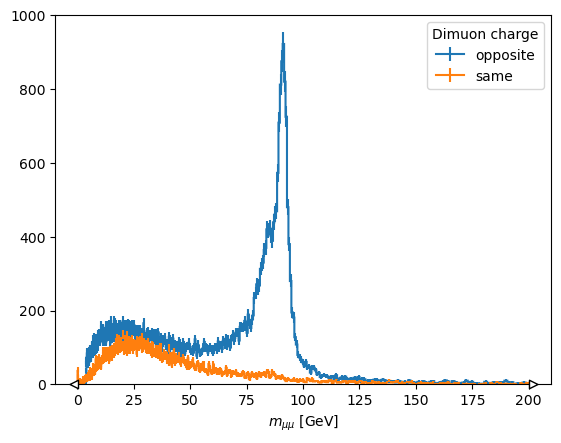

In [53]:
fig, ax = plt.subplots()
out["ZZTo4mu"]["mass"].plot1d(ax=ax)
ax.legend(title="Dimuon charge")
plt.show()

## Processing and Scaling

To process multiple files and data at scale in general we need to construct a "fileset" first. The fileset specifies our datasets, their files and potentially metadata too.

In [54]:
fileset = {
    "SMHiggsToZZTo4L": {
        "files": {
            "data/SMHiggsToZZTo4L.root": "Events",
        },
        "metadata": {
            "is_mc": True,
        },
    },
    "ZZTo4mu": {
        "files": {
            "data/ZZTo4mu.root": "Events",
        },
        "metadata": {
            "is_mc": True,
        },
    },
}

And then we can define an executor and run the processor over all our datasets and their files in chunks and aggregate the results. Let's start by doing that iteratively.

In [55]:
iterative_run = processor.Runner(
    executor=processor.IterativeExecutor(compression=None),
    schema=BaseSchema,
    chunksize=100_000,
    savemetrics=True,
)

out, metrics = iterative_run(
    fileset,
    processor_instance=MyProcessor(),
)
out, metrics

Output()

Output()

({'SMHiggsToZZTo4L': {'entries': 299973,
   'mass': Hist(
     StrCategory(['opposite', 'same'], name='sign'),
     Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Int64()) # Sum: 85798.0 (85838.0 with flow)},
  'ZZTo4mu': {'entries': 500000,
   'mass': Hist(
     StrCategory(['opposite', 'same'], name='sign'),
     Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Int64()) # Sum: 96495.0 (96701.0 with flow)}},
 {'bytesread': 38037638,
  'columns': ['Muon_eta', 'Muon_mass', 'Muon_charge', 'Muon_pt', 'Muon_phi'],
  'entries': 799973,
  'processtime': 0.352858304977417,
  'chunks': 8})

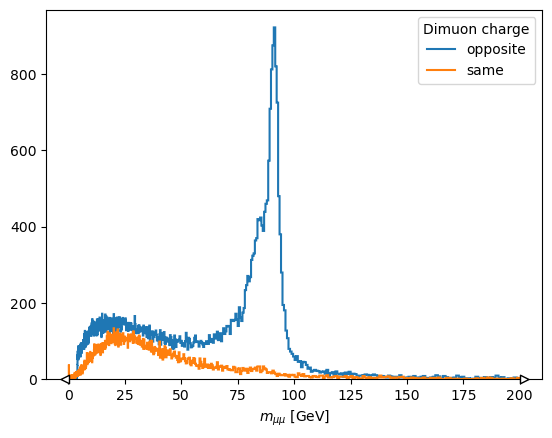

In [56]:
fig, ax = plt.subplots()
out["ZZTo4mu"]["mass"].plot1d(ax=ax)
ax.legend(title="Dimuon charge")
plt.show()

Now, if we want to use more than a single core on our machine, we simply change `IterativeExecutor` for `FuturesExecutor`, which uses the python `concurrent.futures` standard library. We can then set the most interesting argument to the `FuturesExecutor`: the number of cores to use.

In [57]:
futures_run = processor.Runner(
    executor=processor.FuturesExecutor(workers=4, compression=None),
    schema=BaseSchema,
    chunksize=100_000,
    savemetrics=True,
)

out, metrics = futures_run(
    fileset,
    processor_instance=MyProcessor(),
)
out, metrics

Output()

({'SMHiggsToZZTo4L': {'entries': 299973,
   'mass': Hist(
     StrCategory(['opposite', 'same'], name='sign'),
     Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Int64()) # Sum: 85798.0 (85838.0 with flow)},
  'ZZTo4mu': {'entries': 500000,
   'mass': Hist(
     StrCategory(['opposite', 'same'], name='sign'),
     Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Int64()) # Sum: 96495.0 (96701.0 with flow)}},
 {'bytesread': 38037638,
  'columns': ['Muon_eta', 'Muon_mass', 'Muon_charge', 'Muon_pt', 'Muon_phi'],
  'entries': 799973,
  'processtime': 0.41587018966674805,
  'chunks': 8})

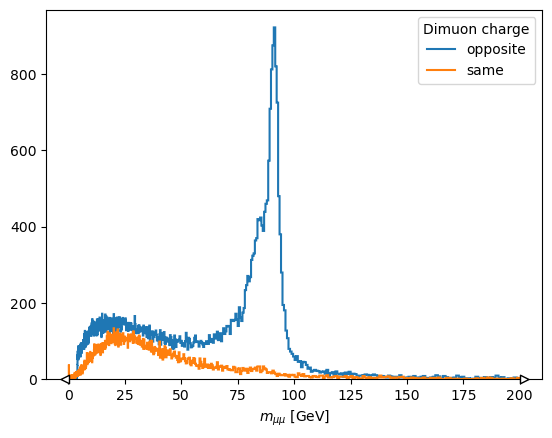

In [58]:
fig, ax = plt.subplots()
out["ZZTo4mu"]["mass"].plot1d(ax=ax)
ax.legend(title="Dimuon charge")
plt.show()

Or you can scale accross whole clusters using the `DaskExecutor` which connects to a `dask` client or others like `ParslExecutor` and `TaskVineExecutor`. More executors can be implemented somewhat easily if your computing infrastructure requires them

In [59]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 62.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34285,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.01 GiB
Comm: tcp://127.0.0.1:43697,Total threads: 1
Dashboard: http://127.0.0.1:38231/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:33969,


In [60]:
dask_run = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
    chunksize=100_000,
    skipbadfiles=True,
    savemetrics=True,
)

out, metrics = dask_run(
    fileset,
    processor_instance=MyProcessor(),
)
out, metrics

Output()

({'SMHiggsToZZTo4L': {'entries': 299973,
   'mass': Hist(
     StrCategory(['opposite', 'same'], name='sign'),
     Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Int64()) # Sum: 85798.0 (85838.0 with flow)},
  'ZZTo4mu': {'entries': 500000,
   'mass': Hist(
     StrCategory(['opposite', 'same'], name='sign'),
     Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Int64()) # Sum: 96495.0 (96701.0 with flow)}},
 {'bytesread': 38037638,
  'columns': ['Muon_eta', 'Muon_mass', 'Muon_charge', 'Muon_pt', 'Muon_phi'],
  'entries': 799973,
  'processtime': 0.45664143562316895,
  'chunks': 8})

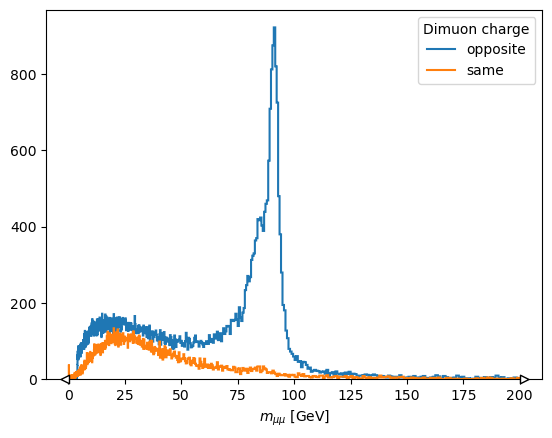

In [61]:
fig, ax = plt.subplots()
out["ZZTo4mu"]["mass"].plot1d(ax=ax)
ax.legend(title="Dimuon charge")
plt.show()

Your analysis code is completely independent of the compute infrastructure! You just need to express how to process an arbitrary chunk of events and scaling is then seamless!

### Checkpointing

Often, the workflow can crash due to reasons beyond our control. An error due to reading over `xrootd`, workers dying can crash our whole workflow. `skipbadfiles` mitigates for that because it runs every single chunk in a try-except block and will catch the error and not raise it. But in that case, if errors happen, you fail to run over some chunks of events. How do you continue from that point? Coffea provides a checkpointing functionality.

In [62]:
import random
import awkward as ak
from datetime import datetime

from coffea import processor
from coffea.nanoevents import NanoAODSchema


class UnstableNanoEventsProcessor(processor.ProcessorABC):
    @property
    def accumulator(self):
        return {"cutflow": {}}

    def process(self, events):
        if random.random() < 0.75:
            raise OSError("Random failure for testing checkpointing")

        output = self.accumulator
        dataset = events.metadata["dataset"]
        output["cutflow"]["%s_pt" % dataset] = ak.sum(ak.num(events.Muon, axis=1))
        return output

    def postprocess(self, accumulator):
        return accumulator


today = datetime.now().strftime("%Y%m%d")
checkpointer = processor.SimpleCheckpointer(
    checkpoint_dir=f"checkpoints/{today}", verbose=True
)

iterative_run = processor.Runner(
    executor=processor.IterativeExecutor(compression=None),
    schema=NanoAODSchema,
    chunksize=100_000,
    savemetrics=True,
    skipbadfiles=True,
    checkpointer=checkpointer,
)

out, metrics = iterative_run(
    fileset,
    processor_instance=UnstableNanoEventsProcessor(),
)
out, metrics

Output()

Checkpoint file 
/home/iason/Dropbox/fun/pyhep2025-coffea/checkpoints/20251023/SMHiggsToZZTo4L/9f98a208-bebc-11eb-9992-c4650d81beef/
Events/0-99991.coffea does not exist. May be the first run...

/home/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/processor/executor.py:1128: UserWarning: Failed processing 
file: WorkItem(dataset='SMHiggsToZZTo4L', filename='data/SMHiggsToZZTo4L.root', treename='Events', entrystart=0, 
entrystop=99991, fileuuid=b'\x9f\x98\xa2\x08\xbe\xbc\x11\xeb\x99\x92\xc4e\r\x81\xbe\xef', usermeta={'is_mc': 
True}). The error was: OSError('Random failure for testing checkpointing').
  warnings.warn(str(e))

Checkpoint file 
/home/iason/Dropbox/fun/pyhep2025-coffea/checkpoints/20251023/SMHiggsToZZTo4L/9f98a208-bebc-11eb-9992-c4650d81beef/
Events/199982-299973.coffea does not exist. May be the first run...

Checkpoint file 
/home/iason/Dropbox/fun/pyhep2025-coffea/checkpoints/20251023/ZZTo4mu/6d83675a-354a-11ef-9da0-60af0cc2beef/Events/0
-100000.coffea does not exist. May be the first run...

/home/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/processor/executor.py:1128: UserWarning: Failed processing 
file: WorkItem(dataset='ZZTo4mu', filename='data/ZZTo4mu.root', treename='Events', entrystart=0, entrystop=100000, 
fileuuid=b'm\x83gZ5J\x11\xef\x9d\xa0`\xaf\x0c\xc2\xbe\xef', usermeta={'is_mc': True}). The error was: 
OSError('Random failure for testing checkpointing').
  warnings.warn(str(e))

Checkpoint file 
/home/iason/Dropbox/fun/pyhep2025-coffea/checkpoints/20251023/ZZTo4mu/6d83675a-354a-11ef-9da0-60af0cc2beef/Events/1
00000-200000.coffea does not exist. May be the first run...

/home/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/processor/executor.py:1128: UserWarning: Failed processing 
file: WorkItem(dataset='ZZTo4mu', filename='data/ZZTo4mu.root', treename='Events', entrystart=100000, 
entrystop=200000, fileuuid=b'm\x83gZ5J\x11\xef\x9d\xa0`\xaf\x0c\xc2\xbe\xef', usermeta={'is_mc': True}). The error 
was: OSError('Random failure for testing checkpointing').
  warnings.warn(str(e))

Checkpoint file 
/home/iason/Dropbox/fun/pyhep2025-coffea/checkpoints/20251023/ZZTo4mu/6d83675a-354a-11ef-9da0-60af0cc2beef/Events/2
00000-300000.coffea does not exist. May be the first run...

/home/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/processor/executor.py:1128: UserWarning: Failed processing 
file: WorkItem(dataset='ZZTo4mu', filename='data/ZZTo4mu.root', treename='Events', entrystart=200000, 
entrystop=300000, fileuuid=b'm\x83gZ5J\x11\xef\x9d\xa0`\xaf\x0c\xc2\xbe\xef', usermeta={'is_mc': True}). The error 
was: OSError('Random failure for testing checkpointing').
  warnings.warn(str(e))

Checkpoint file 
/home/iason/Dropbox/fun/pyhep2025-coffea/checkpoints/20251023/ZZTo4mu/6d83675a-354a-11ef-9da0-60af0cc2beef/Events/3
00000-400000.coffea does not exist. May be the first run...

/home/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/processor/executor.py:1128: UserWarning: Failed processing 
file: WorkItem(dataset='ZZTo4mu', filename='data/ZZTo4mu.root', treename='Events', entrystart=300000, 
entrystop=400000, fileuuid=b'm\x83gZ5J\x11\xef\x9d\xa0`\xaf\x0c\xc2\xbe\xef', usermeta={'is_mc': True}). The error 
was: OSError('Random failure for testing checkpointing').
  warnings.warn(str(e))

Checkpoint file 
/home/iason/Dropbox/fun/pyhep2025-coffea/checkpoints/20251023/ZZTo4mu/6d83675a-354a-11ef-9da0-60af0cc2beef/Events/4
00000-500000.coffea does not exist. May be the first run...

/home/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/processor/executor.py:1128: UserWarning: Failed processing 
file: WorkItem(dataset='ZZTo4mu', filename='data/ZZTo4mu.root', treename='Events', entrystart=400000, 
entrystop=500000, fileuuid=b'm\x83gZ5J\x11\xef\x9d\xa0`\xaf\x0c\xc2\xbe\xef', usermeta={'is_mc': True}). The error 
was: OSError('Random failure for testing checkpointing').
  warnings.warn(str(e))

({'cutflow': {'SMHiggsToZZTo4L_pt': np.int64(293720)}},
 {'bytesread': 180501,
  'columns': ['nMuon'],
  'entries': 199982,
  'processtime': 0.005756855010986328,
  'chunks': 8})

## Tracing and preloading

Finally, I would like to talk about a couple more features of `NanoEvents` that will soon be part of processing/executing too.
The virtual array implementation means that each root branch will be loaded from the root file sequentially when it is first needed wth separate network requests. It is generally more efficient to make a single netgwork request for all the branches.

### Preloading

We provide a pre-loading capability where the user can specify some branches to pre-load they they know they are going to need.

In [63]:
filename = "data/ZZTo4mu.root"
access_log = []
preload = lambda b: b.name == "nMuon" or b.name == "Muon_pt"

events = NanoEventsFactory.from_root(
    {filename: "Events"},
    mode="virtual",
    access_log=access_log,
    preload=preload,
).events()

In [64]:
%timeit -n 1 -r 1 ak.materialize(events.Muon.eta)

25 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [65]:
%timeit -n 1 -r 1 ak.materialize(events.Muon.pt)

841 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [66]:
access_log

['nMuon', 'Muon_eta', 'Muon_pt']

### Tracing

But how do I know which branches I am gonna need? Some times it's obvious. Other times, it's not. But, you can "trace" thorugh a processor without loading any data to find out "as much as you can" in a try-except fashion because tracing has limitations (you can't make data-dependent decisions for example because there is no data to decide on)

In [67]:
filename = "data/ZZTo4mu.root"
access_log = []
events = NanoEventsFactory.from_root(
    {filename: "Events"},
    metadata={"dataset": "ZZTo4mu"},
    schemaclass=BaseSchema,
    mode="virtual",
    access_log=access_log,
).events()
access_log

[]

In [68]:
from coffea.nanoevents.trace import trace

necessary_columns = trace(MyProcessor().process, events)
necessary_columns, access_log

/tmp/ipykernel_297336/3007545806.py:3: RuntimeWarning: Exception during typetracer tracing: Converting from an nplike without known data to an nplike with known data is not supported
  necessary_columns = trace(MyProcessor().process, events)


(frozenset({'Muon_charge', 'Muon_eta', 'Muon_mass', 'Muon_phi', 'Muon_pt'}),
 [])

### Tracing and preloading

Naturally, these two features play very well together. You can ask to pre-load what the tracing stage found as needed.

In [69]:
preload = lambda b: b.name in necessary_columns

filename = "data/ZZTo4mu.root"
access_log = []
events = NanoEventsFactory.from_root(
    {filename: "Events"},
    metadata={"dataset": "ZZTo4mu"},
    mode="virtual",
    schemaclass=BaseSchema,
    access_log=access_log,
    preload=preload,
).events()

out = MyProcessor().process(events)
out, sorted(set(access_log))

({'ZZTo4mu': {'entries': 500000,
   'mass': Hist(
     StrCategory(['opposite', 'same'], name='sign'),
     Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Int64()) # Sum: 96495.0 (96701.0 with flow)}},
 ['Muon_charge', 'Muon_eta', 'Muon_mass', 'Muon_phi', 'Muon_pt'])

The goal is to have these optional features as part of the processing/executing stage as some form of pre-processing.